Imports

In [2]:
%matplotlib inline
import numpy as np
import json

from VQA.PythonHelperTools.vqaTools.vqa import VQA
from VQA.PythonEvaluationTools.vqaEvaluation.vqaEval import VQAEval
import random
import skimage.io as io
import matplotlib
import matplotlib.pyplot as plt
import os

from sklearn.utils import shuffle
import spacy
import operator
from operator import itemgetter
from tqdm import tqdm
import cPickle as pickle

In [3]:
import keras
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils, generic_utils
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Activation, Dropout, LSTM, GRU, Flatten, Embedding, RepeatVector
from keras.layers import Merge, Reshape, RepeatVector, BatchNormalization, Lambda, TimeDistributed, Permute
from keras.layers import GlobalMaxPooling2D, Convolution2D, merge, Bidirectional
from keras.regularizers import l2
from keras.optimizers import *
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50

from keras import backend as K
from imagenet_utils import preprocess_input

Using TensorFlow backend.


Constants

In [4]:
dataDir='VQA'
taskType='OpenEnded'
dataType='mscoco' # 'mscoco' for real and 'abstract_v002' for abstract

In [5]:
#nlp = spacy.load('en')
nlp = spacy.load('en', vectors='en_glove_cc_300_1m_vectors')

Load train data

In [6]:
dataSubType_train = 'train2014'
annFile_train     = '%s/Annotations/%s_%s_annotations.json'%(dataDir, dataType, dataSubType_train)
quesFile_train    = '%s/Questions/%s_%s_%s_questions.json'%(dataDir, taskType, dataType, dataSubType_train)
imgDir_train      = '%s/Images/%s/%s/' %(dataDir, dataType, dataSubType_train)
vqa_train         = VQA(annFile_train, quesFile_train)

loading VQA annotations and questions into memory...
0:00:05.805264
creating index...
index created!


In [7]:
dataSubType_val   = 'val2014'
annFile_val       = '%s/Annotations/%s_%s_annotations.json'%(dataDir, dataType, dataSubType_val)
quesFile_val      = '%s/Questions/%s_%s_%s_questions.json'%(dataDir, taskType, dataType, dataSubType_val)
imgDir_val        = '%s/Images/%s/%s/' %(dataDir, dataType, dataSubType_val)
vqa_val           = VQA(annFile_val, quesFile_val)

loading VQA annotations and questions into memory...
0:00:02.266254
creating index...
index created!


Optional to run (just showing the VQA API capabilities)

Question: How many bodies can you see in this image?
Answer 1: 4
Answer 2: 4
Answer 3: 1
Answer 4: 1
Answer 5: 1
Answer 6: 1
Answer 7: 3
Answer 8: 1
Answer 9: 1
Answer 10: 3


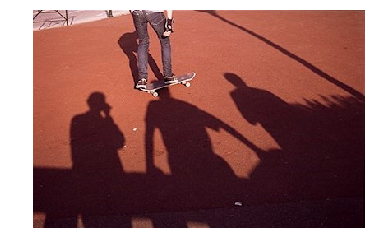

In [7]:
# load and display QA annotations for given question types
"""
All possible quesTypes for abstract and mscoco has been provided in respective text files in ../QuestionTypes/ folder.
"""
annIds = vqa_train.getQuesIds(quesTypes='how many');   
anns = vqa_train.loadQA(annIds)
randomAnn = random.choice(anns)
vqa_train.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType_train + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir_train + imgFilename):
    I = io.imread(imgDir_train + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()
else: print(imgDir_train + imgFilename)

Question: Is the glass full of water?
Answer 1: no
Answer 2: no
Answer 3: no
Answer 4: no
Answer 5: no
Answer 6: no
Answer 7: no
Answer 8: no
Answer 9: no
Answer 10: no


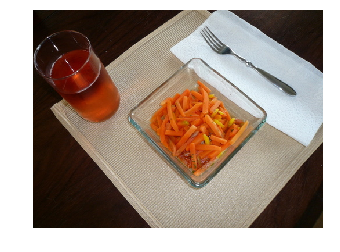

In [8]:
# load and display QA annotations for given answer types
"""
ansTypes can be one of the following
yes/no
number
other
"""
annIds = vqa_train.getQuesIds(ansTypes='yes/no');   
anns = vqa_train.loadQA(annIds)
randomAnn = random.choice(anns)
vqa_train.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType_train + '_'+ str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir_train + imgFilename):
    I = io.imread(imgDir_train + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()

Question: What shape is the lamp in the room?
Answer 1: no lamp
Answer 2: square
Answer 3: circle
Answer 4: round
Answer 5: round
Answer 6: round
Answer 7: circle
Answer 8: sphere
Answer 9: round
Answer 10: round


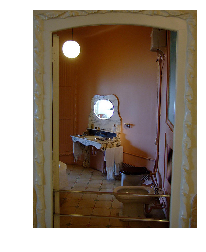

In [9]:
# load and display QA annotations for given images
"""
Usage: vqa.getImgIds(quesIds=[], quesTypes=[], ansTypes=[])
Above method can be used to retrieve imageIds for given question Ids or given question types or given answer types.
"""
ids = vqa_train.getImgIds()
annIds = vqa_train.getQuesIds(imgIds=random.sample(ids, 5));
anns = vqa_train.loadQA(annIds)
randomAnn = random.choice(anns)
vqa_train.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType_train + '_' + str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir_train + imgFilename):
    I = io.imread(imgDir_train + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()

Question: Which wrist has a sweatband?
Answer 1: right
Answer 2: her right
Answer 3: right
Answer 4: right
Answer 5: right
Answer 6: right
Answer 7: right
Answer 8: right wrist
Answer 9: right
Answer 10: right


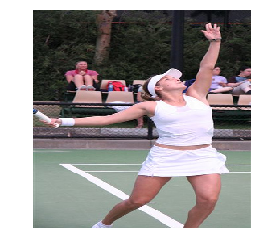

In [10]:
annIds = vqa_train.getQuesIds()
anns = vqa_train.loadQA(annIds)
randomAnn = random.choice(anns)
vqa_train.showQA([randomAnn])
imgId = randomAnn['image_id']
imgFilename = 'COCO_' + dataSubType_train + '_' + str(imgId).zfill(12) + '.jpg'
if os.path.isfile(imgDir_train + imgFilename):
    '''
    I = io.imread(imgDir_train + imgFilename)
    plt.imshow(I)
    plt.axis('off')
    plt.show()
    
    '''
    img = image.load_img(imgDir_train + imgFilename, target_size=(224, 224))
    x = image.img_to_array(img)
    x = preprocess_input(x)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [11]:
annIds = vqa_train.getQuesIds()
anns = vqa_train.loadQA(annIds)
anns = shuffle(anns, random_state=0)
num_batches = len(anns) // batch_size + (1 if len(anns) % batch_size > 0 else 0)

#print num_batches
i = 2
anns_batch = anns[i * batch_size : min((i + 1) * batch_size, len(anns))]
#print len(anns_batch)

ann = anns_batch[0]
print ann
print vqa_train.qqa[ann['question_id']]['question']

question = nlp(vqa_train.qqa[ann['question_id']]['question'])
for w in question:
    print (w.text, w.pos_, len(w.vector))
    
question_word_vec = [w.vector for w in question]

{u'question_type': u'are the', u'multiple_choice_answer': u'no', u'answers': [{u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 1}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 2}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 3}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 4}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 5}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 6}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 7}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 8}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 9}, {u'answer': u'no', u'answer_confidence': u'yes', u'answer_id': 10}], u'image_id': 363205, u'answer_type': u'yes/no', u'question_id': 3632051}
Are the planes in flight?
(u'Are', u'VERB', 300)
(u'the', u'DET', 300)
(u'planes', u'NOUN', 300)
(u'in', u'ADP', 300)
(u'flight', u'NOUN', 300)
(u'?', u'PUNCT', 300)


## Process data

Modify the call to get_most_common_answers to 1000 or 3000 depending on the model used

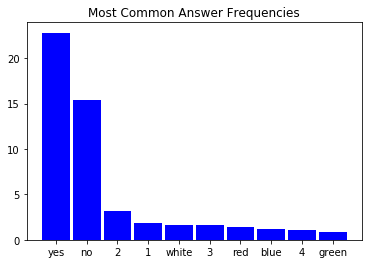

In [69]:
def get_most_common_answers(num_answers):
    ans_dict = {}
    annIds = vqa_train.getQuesIds()
    anns = vqa_train.loadQA(annIds)
    for ann in anns:
        for ans in ann['answers']:
            answer = ans['answer'].lower()
            if answer in ans_dict:
                ans_dict[answer] += 1
            else:
                ans_dict[answer] = 1
        '''
        if ann['multiple_choice_answer'] in ans_dict:
            ans_dict[ann['multiple_choice_answer']] += 1
        else:
            ans_dict[ann['multiple_choice_answer']] = 1
        '''
    sorted_ans_dict = sorted(ans_dict.items(), key=itemgetter(1), reverse=True)
    
    # Some bar plots
    num_ans_plot = 10
    total_ans = 0
    for (x,y) in sorted_ans_dict: total_ans += y
    plt.bar(range(1, num_ans_plot+1), [float(y) / total_ans * 100 for (x,y) in sorted_ans_dict[0:num_ans_plot]], 0.9, color='b')
    plt.xticks(range(1, num_ans_plot+1), [x for (x,y) in sorted_ans_dict[0:num_ans_plot]])
    plt.title("Most Common Answer Frequencies")
    plt.show()
    
    sorted_ans_dict = [x for (x,y) in sorted_ans_dict]
    sorted_ans_dict = sorted_ans_dict[0:num_answers]

    ans_to_id = dict((a, i) for i, a in enumerate(sorted_ans_dict))
    id_to_ans = dict((i, a) for i, a in enumerate(sorted_ans_dict))
    return ans_to_id, id_to_ans

ans_to_id, id_to_ans = get_most_common_answers(3000)

In [43]:
def process_question(vqa, ann):
    quesId = ann['question_id']
    if quesId in question_word_vec_map:
        return question_word_vec_map[quesId]
    question = nlp(vqa.qqa[quesId]['question'])
    question_word_vec = [w.vector for w in question]

    return np.array(question_word_vec)

In [44]:
def process_answer(vqa, ann):
    quesId = ann['question_id']
    if quesId in ans_map:
        return ans_map[quesId]
    answer = ann['multiple_choice_answer'].lower() 
    if answer in ans_to_id:
        encoding = np.zeros(len(id_to_ans))
        encoding[ans_to_id[answer]] = 1
        return encoding
    else:
        return None

In [45]:
# VGG 19 post-convolution layers
model = VGG19(weights='imagenet', include_top=False)

def process_img(vqa, ann, dataSubType, imgDir):
    imgId = ann['image_id']
    imgFilename = 'COCO_' + dataSubType + '_' + str(imgId).zfill(12) + '.jpg'
    if os.path.isfile(imgDir + imgFilename):
        img = image.load_img(imgDir + imgFilename, target_size=(224, 224))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        features = model.predict(np.array([x]))
        features = np.reshape(features[0], (512, 49))
        return features
    else:
        return None

In [46]:
# VGG 19 fc2 layer
base_model = VGG19(weights='imagenet', include_top=True)
model = Model(input=base_model.input, output=base_model.get_layer('fc2').output)

def process_img(vqa, ann, dataSubType, imgDir):   
    imgId = ann['image_id']
    imgFilename = 'COCO_' + dataSubType + '_' + str(imgId).zfill(12) + '.jpg'
    if os.path.isfile(imgDir + imgFilename):
        img = image.load_img(imgDir + imgFilename, target_size=(224, 224))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        features = model.predict(np.array([x]))
        features = np.reshape(features[0], (4096,))
        return features
    else:
        return None

/home/crisojog/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fc..., inputs=Tensor("in...)`
  app.launch_new_instance()


In [70]:
question_word_vec_map = {}
ans_map = {}
img_map = {}
ques_to_img = {}

In [47]:
annIds = vqa_train.getQuesIds()
anns = vqa_train.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    if quesId in question_word_vec_map: 
        continue

    question = process_question(vqa_train, ann)
    if question is None: 
        continue
    
    question_word_vec_map[quesId] = question

100%|██████████| 248349/248349 [01:05<00:00, 3763.20it/s]


In [48]:
f = open("data/train_questions.pkl", "w")
pickle.dump(question_word_vec_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [71]:
annIds = vqa_train.getQuesIds()
anns = vqa_train.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    if quesId in ans_map: 
        continue

    answer = process_answer(vqa_train, ann)
    if answer is None: 
        continue

    ans_map[quesId] = answer.tolist()

100%|██████████| 248349/248349 [00:22<00:00, 10805.08it/s]


In [72]:
f = open("data/train_answers.pkl", "w")
pickle.dump(ans_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [16]:
annIds = vqa_train.getQuesIds()
anns = vqa_train.loadQA(annIds)

for ann in tqdm(anns):
    imgId = int(ann['image_id'])
    if imgId in img_map:
        continue
        
    img = process_img(vqa_train, ann, dataSubType_train, imgDir_train)
    if img is None: 
        continue

    img_map[imgId] = img

100%|██████████| 248349/248349 [20:37<00:00, 200.67it/s]


In [17]:
f = open("data/train_images.pkl", "w")
pickle.dump(img_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [16]:
annIds = vqa_train.getQuesIds()
anns = vqa_train.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    imgId = int(ann['image_id'])
    ques_to_img[quesId] = imgId

100%|██████████| 248349/248349 [00:00<00:00, 705176.32it/s]


In [17]:
f = open("data/train_ques_to_img.pkl", "w")
pickle.dump(ques_to_img, f, pickle.HIGHEST_PROTOCOL)
f.close()

Now for the validation set

In [73]:
question_word_vec_map = {}
ans_map = {}
img_map = {}
ques_to_img = {}

In [50]:
annIds = vqa_val.getQuesIds()
anns = vqa_val.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    if quesId in question_word_vec_map: 
        continue

    question = process_question(vqa_val, ann)
    if question is None: 
        continue
    
    question_word_vec_map[quesId] = question

100%|██████████| 121512/121512 [00:35<00:00, 3422.20it/s]


In [51]:
f = open("data/val_questions.pkl", "w")
pickle.dump(question_word_vec_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [74]:
annIds = vqa_val.getQuesIds()
anns = vqa_val.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    if quesId in ans_map: 
        continue

    answer = process_answer(vqa_val, ann)
    if answer is None: 
        continue

    ans_map[quesId] = answer

100%|██████████| 121512/121512 [00:00<00:00, 244306.60it/s]


In [75]:
f = open("data/val_answers.pkl", "w")
pickle.dump(ans_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [25]:
annIds = vqa_val.getQuesIds()
anns = vqa_val.loadQA(annIds)

for ann in tqdm(anns):
    imgId = int(ann['image_id'])
    if imgId in img_map:
        continue
        
    img = process_img(vqa_val, ann, dataSubType_val, imgDir_val)
    if img is None: 
        continue

    img_map[imgId] = img

100%|██████████| 121512/121512 [10:51<00:00, 186.48it/s]


In [26]:
f = open("data/val_images.pkl", "w")
pickle.dump(img_map, f, pickle.HIGHEST_PROTOCOL)
f.close()

In [23]:
annIds = vqa_val.getQuesIds()
anns = vqa_val.loadQA(annIds)

for ann in tqdm(anns):
    quesId = int(ann['question_id'])
    imgId = int(ann['image_id'])
    ques_to_img[quesId] = imgId

100%|██████████| 121512/121512 [00:00<00:00, 747107.81it/s]


In [24]:
f = open("data/val_ques_to_img.pkl", "w")
pickle.dump(ques_to_img, f, pickle.HIGHEST_PROTOCOL)
f.close()

### Run these to prepare dataset for training

In [76]:
print "Loading train questions"
ques_train_map = pickle.load(open("data/train_questions.pkl","r"))
print "Loading train answers"
ans_train_map = pickle.load(open("data/train_answers.pkl","r"))
print "Loading train images"
img_train_map = pickle.load(open("data/train_images.pkl","r"))
print "Loading ques_to_img map"
ques_to_img_train = pickle.load(open("data/train_ques_to_img.pkl","r"))
print "Done"

Loading train questions
Loading train answers
Loading train images
Loading ques_to_img map
Done


In [77]:
print "Loading validation questions"
ques_val_map = pickle.load(open("data/val_questions.pkl","r"))
print "Loading validation answers"
ans_val_map = pickle.load(open("data/val_answers.pkl","r"))
print "Loading validation images"
img_val_map = pickle.load(open("data/val_images.pkl","r"))
print "Loading ques_to_img map"
ques_to_img_val = pickle.load(open("data/val_ques_to_img.pkl","r"))
print "Done"

Loading validation questions
Loading validation answers
Loading validation images
Loading ques_to_img map
Done


In [78]:
ques_train_ids = np.array(ques_train_map.keys())
ques_val_ids = np.array(ques_val_map.keys())
train_dim, val_dim = len(ques_train_ids), len(ques_val_ids)
print train_dim, val_dim

248349 121512


### Train model helper functions

In [15]:
def get_batch(batch, batch_size, ques_map, ans_map, img_map, ques_ids, ques_to_img):
    # get ids in the current batch
    batch_ids = ques_ids[batch * batch_size: min((batch + 1) * batch_size, len(ques_ids))]
    # filter out ids which don't have question, answer or image
    batch_ids = [batch_id for batch_id in batch_ids if batch_id in ques_map and batch_id in ans_map and ques_to_img[batch_id] in img_map]

    # add questions to batch
    batch_questions = [ques_map[batch_id] for batch_id in batch_ids]
    batch_answers = [ans_map[batch_id] for batch_id in batch_ids]
    batch_images = [img_map[ques_to_img[batch_id]] for batch_id in batch_ids]

    # find out maximum length of a question in this batch
    max_len = max([len(ques) for ques in batch_questions])
    # ... and pad all questions in the batch to that length (more efficient than padding all questions to a single maximum length)
    batch_ques_aligned = []
    for question in batch_questions:
        if len(question) < max_len:
            batch_ques_aligned.append(np.append(question, np.zeros((max_len - len(question), 300)), axis=0))
        else:
            batch_ques_aligned.append(question)
    # finally, construct train_X, and train_y
    train_X = [np.array(batch_images), np.array(batch_ques_aligned)]
    train_y = np.array(batch_answers)
    return train_X, train_y

In [16]:
def train_epoch(
        epoch_no,
        model,
        num_batches, 
        batch_size, 
        ques_map, 
        ans_map, 
        img_map, 
        ques_ids, 
        ques_to_img):
    # shuffle all question ids on each epoch
    np.random.shuffle(ques_ids)
    
    loss, accuracy, total = .0, .0, .0
    for batch in tqdm(range(num_batches), desc="Train epoch %d" % epoch_no):
        train_X, train_y = get_batch(batch, batch_size, ques_map, ans_map, img_map, ques_ids, ques_to_img)
        total += len(train_y)
        # ... and train model with the batch
        l, a = model.train_on_batch(train_X, train_y)
        loss += l * len(train_y)
        accuracy += a * len(train_y)
    loss /= total
    accuracy /= total
    print("Train loss: {}\tAccuracy: {}".format(loss, accuracy))
    return loss, accuracy

In [17]:
def val_epoch(
        epoch_no,
        model, 
        num_batches, 
        batch_size, 
        ques_map, 
        ans_map, 
        img_map, 
        ques_ids,
        ques_to_img):    
    loss, accuracy, total = .0, .0, .0
    for batch in tqdm(range(num_batches), desc="Val epoch %d" % epoch_no):    
        val_X, val_y = get_batch(batch, batch_size, ques_map, ans_map, img_map, ques_ids, ques_to_img)
        total += len(val_y)
        l, a = model.test_on_batch(val_X, val_y)
        loss += l * len(val_y)
        accuracy += a * len(val_y)
    loss /= total
    accuracy /= total
    print("Val loss: {}\tAccuracy: {}".format(loss, accuracy))
    return loss, accuracy

In [18]:
# constants for evaluation

taskType = 'OpenEnded'
dataType = 'mscoco'  # 'mscoco' for real and 'abstract_v002' for abstract
dataSubType = 'val2014'
annFile = '%s/Annotations/%s_%s_annotations.json' % (dataDir, dataType, dataSubType)
quesFile = '%s/Questions/%s_%s_%s_questions.json' % (dataDir, taskType, dataType, dataSubType)
imgDir = '%s/Images/%s/%s/' % (dataDir, dataType, dataSubType)
resultType = 'eval'
fileTypes = ['results', 'accuracy', 'evalQA', 'evalQuesType', 'evalAnsType']

[resFile, accuracyFile, evalQAFile, evalQuesTypeFile, evalAnsTypeFile] = \
    ['%s/Results/%s_%s_%s_%s_%s.json' % (dataDir, taskType, dataType, dataSubType, \
                                         resultType, fileType) for fileType in fileTypes]

In [19]:
def process_question_batch(questions, question_ids, images, results):
    # find out maximum length of a question in this batch
    max_len = max([len(ques) for ques in questions])
    # ... and pad all questions in the batch to that length (more efficient than padding all questions to a single maximum length)
    ques_aligned = []
    for question in questions:
        if len(question) < max_len:
            ques_aligned.append(np.append(question, np.zeros((max_len - len(question), 300)), axis=0))
        else:
            ques_aligned.append(question)            
    val_X = [np.array(images), np.array(ques_aligned)]

    predicted_y = model.predict_on_batch(val_X)
    # add results to map
    for ans, question_id in zip(predicted_y, question_ids):
        res = {}
        res['question_id'] = int(question_id)
        # NOTE: we get the best answer via argmax, NOT through sampling (TODO)
        res['answer'] = id_to_ans[np.argmax(ans)]
        results.append(res)

def print_accuracies(vqaEval):
    print "\n"
    print "Overall Accuracy is: %.02f\n" % (vqaEval.accuracy['overall'])
    print "Per Question Type Accuracy is the following:"
    for quesType in vqaEval.accuracy['perQuestionType']:
        print "%s : %.02f" % (quesType, vqaEval.accuracy['perQuestionType'][quesType])
    print "\n"
    print "Per Answer Type Accuracy is the following:"
    for ansType in vqaEval.accuracy['perAnswerType']:
        print "%s : %.02f" % (ansType, vqaEval.accuracy['perAnswerType'][ansType])
    print "\n"

def evaluate(
        vqa,
        model, 
        batch_size, 
        ques_map, 
        ans_map, 
        img_map,
        id_to_ans,
        verbose=False):    

    annIds = vqa.getQuesIds();
    anns = vqa.loadQA(annIds)
    
    questions = []
    question_ids = []
    images = []

    results = []
    for ann in tqdm(anns):
        questions.append(ques_map[ann['question_id']])
        question_ids.append(ann['question_id'])
        images.append(img_map[ann['image_id']])
        if len(questions) == batch_size:
            process_question_batch(questions, question_ids, images, results)
            # clear arrays
            questions, question_ids, images = [], [], []
    if len(questions) > 0:
        process_question_batch(questions, question_ids, images, results)
    
    # save results as a json
    with open(resFile,"w") as outfile:
        json.dump(results, outfile)
    
    # create vqa object and vqaRes object
    vqa_ann = VQA(annFile, quesFile)
    vqaRes = vqa_ann.loadRes(resFile, quesFile)

    # create vqaEval object by taking vqa and vqaRes
    vqaEval = VQAEval(vqa_ann, vqaRes, n=2)  # n is precision of accuracy (number of places after decimal), default is 2
    
    vqaEval.evaluate()
    
    if verbose:
        print_accuracies(vqaEval)
    
    return vqaEval.accuracy['overall']

### Model 1

In [56]:
def Word2VecModel(embedding_dim, dropout_rate):
    print("Creating text model...")
    model = Sequential()
    model.add(LSTM(units=512, return_sequences=True, input_shape=(None, embedding_dim)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=512, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1024, activation='tanh'))
    return model


def img_model(dropout_rate):
    print("Creating image model...")
    model = Sequential()
    model.add(Dense(1024, input_dim=4096, activation='tanh'))
    return model


def vqa_model(embedding_dim, dropout_rate, num_classes):
    vgg_model = img_model(dropout_rate)
    lstm_model = Word2VecModel(embedding_dim, dropout_rate)
    print("Merging final model...")
    fc_model = Sequential()
    fc_model.add(Merge([vgg_model, lstm_model], mode='mul'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(1000, activation='tanh'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(num_classes, activation='softmax'))
    fc_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                     metrics=['accuracy'])
    return fc_model

In [60]:
# model parameters
dropout_rate = 0.5
embedding_size = 300
num_classes = 1000

# training parameters
num_epochs = 80
batch_size = 1000
num_batches_train = train_dim // batch_size
num_batches_val = val_dim // batch_size
eval_every = 5

train_loss, train_acc = [], []
val_loss, val_acc = [], []
eval_acc = []

In [61]:
model = vqa_model(embedding_size, dropout_rate, num_classes)

Creating image model...
Creating text model...
Merging final model...


/home/crisojog/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [17]:
model.load_weights("models/model_1_weights.h5")

In [62]:
for k in range(num_epochs):
    loss, acc = train_epoch(k + 1, model, num_batches_train, batch_size, ques_train_map, ans_train_map, img_train_map, ques_train_ids, ques_to_img_train)
    train_loss.append(loss)
    train_acc.append(acc)
    loss, acc = val_epoch(k + 1, model, num_batches_val, batch_size, ques_val_map, ans_val_map, img_val_map, ques_val_ids, ques_to_img_val)
    val_loss.append(loss)
    val_acc.append(acc)
    if (k + 1) % eval_every == 0:
        model.save_weights("models/model_1/model_1_epoch_%d_weights.h5" % (k + 1), overwrite=True)
        eval_accuracy = evaluate(vqa_val, model, batch_size, ques_val_map, ans_val_map, img_val_map, id_to_ans)
        print ("Eval accuracy: %.2f" % eval_accuracy)
        eval_acc.append(eval_accuracy)

Val epoch 1:   0%|          | 0/121 [00:00<?, ?it/s]

Train loss: 3.89473977688	Accuracy: 0.268447097465


Train epoch 2:   0%|          | 1/248 [00:00<00:38,  6.45it/s]

Val loss: 2.61513876556	Accuracy: 0.365087018963


Val epoch 2:   2%|▏         | 2/121 [00:00<00:09, 12.25it/s]

Train loss: 2.53933699835	Accuracy: 0.364544324443


Train epoch 3:   0%|          | 1/248 [00:00<00:38,  6.34it/s]

Val loss: 2.26506031973	Accuracy: 0.365337857266


Val epoch 3:   2%|▏         | 2/121 [00:00<00:09, 12.09it/s]

Train loss: 2.24380084248	Accuracy: 0.397194773787


Train epoch 4:   0%|          | 1/248 [00:00<00:41,  5.96it/s]

Val loss: 2.04988661379	Accuracy: 0.430112295671


Val epoch 4:   2%|▏         | 2/121 [00:00<00:09, 12.05it/s]

Train loss: 2.05181003011	Accuracy: 0.421683196354


Train epoch 5:   0%|          | 1/248 [00:00<00:36,  6.80it/s]

Val loss: 1.91400383226	Accuracy: 0.445481033987


Val epoch 5:   2%|▏         | 2/121 [00:00<00:09, 11.99it/s]

Train loss: 1.93680369491	Accuracy: 0.436914598234


Val epoch 5: 100%|██████████| 121/121 [00:09<00:00, 12.63it/s]


Val loss: 1.81333435627	Accuracy: 0.462846829485


100%|██████████| 121512/121512 [00:11<00:00, 10272.23it/s]


loading VQA annotations and questions into memory...
0:00:02.466621
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 6:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 46.48


Val epoch 6:   2%|▏         | 2/121 [00:00<00:09, 11.94it/s]

Train loss: 1.84762512091	Accuracy: 0.453834440919


Train epoch 7:   0%|          | 1/248 [00:00<00:48,  5.11it/s]

Val loss: 1.74723603718	Accuracy: 0.473439969916


Val epoch 7:   2%|▏         | 2/121 [00:00<00:10, 11.82it/s]

Train loss: 1.77840620463	Accuracy: 0.47022321975


Train epoch 8:   0%|          | 1/248 [00:00<00:39,  6.30it/s]

Val loss: 1.69984501409	Accuracy: 0.488528923629


Val epoch 8:   2%|▏         | 2/121 [00:00<00:09, 12.21it/s]

Train loss: 1.7173880418	Accuracy: 0.488019081088


Train epoch 9:   0%|          | 1/248 [00:00<00:43,  5.67it/s]

Val loss: 1.66924615151	Accuracy: 0.493381696584


Val epoch 9:   2%|▏         | 2/121 [00:00<00:10, 11.75it/s]

Train loss: 1.67308453971	Accuracy: 0.501585042108


Train epoch 10:   0%|          | 1/248 [00:00<00:38,  6.37it/s]

Val loss: 1.66695355599	Accuracy: 0.494799904017


Val epoch 10:   2%|▏         | 2/121 [00:00<00:10, 11.82it/s]

Train loss: 1.63732007391	Accuracy: 0.509678586471


  1%|          | 1000/121512 [00:00<00:12, 9756.76it/s]

Val loss: 1.6279172904	Accuracy: 0.50810403958


100%|██████████| 121512/121512 [00:11<00:00, 10712.72it/s]


loading VQA annotations and questions into memory...
0:00:05.610710
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 11:   0%|          | 1/248 [00:00<00:47,  5.16it/s]

Done computing accuracy
Eval accuracy: 50.57


Val epoch 11:   2%|▏         | 2/121 [00:00<00:10, 11.88it/s]

Train loss: 1.60243605895	Accuracy: 0.517271485121


Train epoch 12:   0%|          | 1/248 [00:00<00:35,  6.93it/s]

Val loss: 1.6253870255	Accuracy: 0.507891788263


Val epoch 12:   2%|▏         | 2/121 [00:00<00:10, 11.70it/s]

Train loss: 1.57234284337	Accuracy: 0.526070773067


Train epoch 13:   0%|          | 1/248 [00:00<00:46,  5.35it/s]

Val loss: 1.66121564094	Accuracy: 0.469523014275


Val epoch 13:   2%|▏         | 2/121 [00:00<00:09, 11.99it/s]

Train loss: 1.54447085961	Accuracy: 0.53421829846


Train epoch 14:   0%|          | 1/248 [00:00<00:35,  7.06it/s]

Val loss: 1.59326109519	Accuracy: 0.526241655241


Val epoch 14:   2%|▏         | 2/121 [00:00<00:09, 12.05it/s]

Train loss: 1.51584477152	Accuracy: 0.54044917086


Train epoch 15:   0%|          | 1/248 [00:00<00:46,  5.35it/s]

Val loss: 1.58015007831	Accuracy: 0.530814647355


Val epoch 15:   2%|▏         | 2/121 [00:00<00:09, 12.03it/s]

Train loss: 1.49390632183	Accuracy: 0.546861209019


  1%|          | 1000/121512 [00:00<00:12, 9795.77it/s]

Val loss: 1.59257691201	Accuracy: 0.532039902759


100%|██████████| 121512/121512 [00:11<00:00, 10670.20it/s]


loading VQA annotations and questions into memory...
0:00:05.562902
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 16:   0%|          | 1/248 [00:00<00:48,  5.07it/s]

Done computing accuracy
Eval accuracy: 52.74


Val epoch 16:   2%|▏         | 2/121 [00:00<00:10, 11.73it/s]

Train loss: 1.46906754015	Accuracy: 0.555178400677


Train epoch 17:   0%|          | 1/248 [00:00<00:40,  6.14it/s]

Val loss: 1.58776069384	Accuracy: 0.515195072118


Val epoch 17:   2%|▏         | 2/121 [00:00<00:09, 11.99it/s]

Train loss: 1.44703001339	Accuracy: 0.560692504834


Train epoch 18:   0%|          | 1/248 [00:00<00:40,  6.15it/s]

Val loss: 1.58965333624	Accuracy: 0.526752978753


Val epoch 18:   2%|▏         | 2/121 [00:00<00:09, 11.92it/s]

Train loss: 1.4238966867	Accuracy: 0.568018818422


Train epoch 19:   0%|          | 1/248 [00:00<00:42,  5.79it/s]

Val loss: 1.58245601063	Accuracy: 0.530438390446


Val epoch 19:   2%|▏         | 2/121 [00:00<00:09, 11.91it/s]

Train loss: 1.40314129496	Accuracy: 0.573216909417


Train epoch 20:   0%|          | 1/248 [00:00<00:42,  5.79it/s]

Val loss: 1.58545256548	Accuracy: 0.53230039203


Val epoch 20:   2%|▏         | 2/121 [00:00<00:09, 11.95it/s]

Train loss: 1.3825528906	Accuracy: 0.58145441766


  1%|          | 1000/121512 [00:00<00:12, 9822.70it/s]

Val loss: 1.58670775028	Accuracy: 0.539285299105


100%|██████████| 121512/121512 [00:11<00:00, 10679.52it/s]


loading VQA annotations and questions into memory...
0:00:02.422861
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 21:   0%|          | 1/248 [00:00<00:38,  6.33it/s]

Done computing accuracy
Eval accuracy: 53.28


Val epoch 21:   2%|▏         | 2/121 [00:00<00:09, 11.94it/s]

Train loss: 1.36025600336	Accuracy: 0.589380008473


Train epoch 22:   0%|          | 1/248 [00:00<00:38,  6.41it/s]

Val loss: 1.58632306377	Accuracy: 0.527640566114


Val epoch 22:   2%|▏         | 2/121 [00:00<00:09, 11.95it/s]

Train loss: 1.33991391572	Accuracy: 0.594573392343


Train epoch 23:   0%|          | 1/248 [00:00<00:48,  5.06it/s]

Val loss: 1.61832875508	Accuracy: 0.539217762261


Val epoch 23:   2%|▏         | 2/121 [00:00<00:09, 11.93it/s]

Train loss: 1.31864662781	Accuracy: 0.600930109304


Train epoch 24:   0%|          | 1/248 [00:00<00:40,  6.04it/s]

Val loss: 1.62568470333	Accuracy: 0.540288651789


Val epoch 24:   2%|▏         | 2/121 [00:00<00:10, 11.81it/s]

Train loss: 1.29864696508	Accuracy: 0.608259400886


Train epoch 25:   0%|          | 1/248 [00:00<00:39,  6.30it/s]

Val loss: 1.67528194139	Accuracy: 0.537066333473


Val epoch 25:   2%|▏         | 2/121 [00:00<00:09, 11.94it/s]

Train loss: 1.27963697439	Accuracy: 0.613244367345


  1%|          | 1000/121512 [00:00<00:12, 9849.69it/s]

Val loss: 1.64545764407	Accuracy: 0.540423717947


100%|██████████| 121512/121512 [00:11<00:00, 10734.51it/s]


loading VQA annotations and questions into memory...
0:00:02.435062
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 26:   0%|          | 1/248 [00:00<00:46,  5.29it/s]

Done computing accuracy
Eval accuracy: 53.40


Val epoch 26:   2%|▏         | 2/121 [00:00<00:10, 11.34it/s]

Train loss: 1.25716577039	Accuracy: 0.62079848485


Train epoch 27:   0%|          | 1/248 [00:00<00:38,  6.43it/s]

Val loss: 1.71030790785	Accuracy: 0.533651062341


Val epoch 27:   2%|▏         | 2/121 [00:00<00:09, 11.92it/s]

Train loss: 1.23944286582	Accuracy: 0.62624720258


Train epoch 28:   0%|          | 1/248 [00:00<00:36,  6.82it/s]

Val loss: 1.699479135	Accuracy: 0.539565077062


Val epoch 28:   2%|▏         | 2/121 [00:00<00:09, 11.94it/s]

Train loss: 1.22296704956	Accuracy: 0.634074021477


Train epoch 29:   0%|          | 1/248 [00:00<00:39,  6.18it/s]

Val loss: 1.74913375265	Accuracy: 0.540288657432


Val epoch 29:   2%|▏         | 2/121 [00:00<00:09, 11.97it/s]

Train loss: 1.20693364753	Accuracy: 0.638000737477


Train epoch 30:   0%|          | 1/248 [00:00<00:39,  6.23it/s]

Val loss: 1.7411385313	Accuracy: 0.53743294186


Val epoch 30:   2%|▏         | 2/121 [00:00<00:09, 11.91it/s]

Train loss: 1.18418696304	Accuracy: 0.645514768101


  1%|          | 1000/121512 [00:00<00:12, 9828.11it/s]

Val loss: 1.76532671614	Accuracy: 0.536362055962


100%|██████████| 121512/121512 [00:11<00:00, 10781.05it/s]


loading VQA annotations and questions into memory...
0:00:05.634434
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 31:   0%|          | 1/248 [00:00<00:44,  5.51it/s]

Done computing accuracy
Eval accuracy: 53.13


Val epoch 31:   2%|▏         | 2/121 [00:00<00:09, 11.96it/s]

Train loss: 1.16991394572	Accuracy: 0.648905572084


Train epoch 32:   0%|          | 1/248 [00:00<00:35,  6.88it/s]

Val loss: 1.72295326998	Accuracy: 0.534364989024


Val epoch 32:   2%|▏         | 2/121 [00:00<00:09, 12.10it/s]

Train loss: 1.15482328176	Accuracy: 0.653963594541


Train epoch 33:   0%|          | 1/248 [00:00<00:43,  5.68it/s]

Val loss: 1.75874847719	Accuracy: 0.536062974614


Val epoch 33:   2%|▏         | 2/121 [00:00<00:09, 11.94it/s]

Train loss: 1.13984270902	Accuracy: 0.659594235337


Train epoch 34:   0%|          | 1/248 [00:00<00:40,  6.10it/s]

Val loss: 1.76133727988	Accuracy: 0.537230344397


Val epoch 34:   2%|▏         | 2/121 [00:00<00:09, 12.11it/s]

Train loss: 1.1227101219	Accuracy: 0.664904908795


Train epoch 35:   0%|          | 1/248 [00:00<00:40,  6.16it/s]

Val loss: 1.84832781197	Accuracy: 0.539844862469


Val epoch 35:   2%|▏         | 2/121 [00:00<00:10, 11.87it/s]

Train loss: 1.11041633237	Accuracy: 0.669254863582


  1%|          | 1200/121512 [00:00<00:10, 11999.90it/s]

Val loss: 1.86664464922	Accuracy: 0.53964226216


100%|██████████| 121512/121512 [00:11<00:00, 10815.34it/s]


loading VQA annotations and questions into memory...
0:00:05.303791
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 36:   0%|          | 1/248 [00:00<00:37,  6.56it/s]

Done computing accuracy
Eval accuracy: 53.33


Val epoch 36:   2%|▏         | 2/121 [00:00<00:09, 11.99it/s]

Train loss: 1.09062112496	Accuracy: 0.674180903875


Train epoch 37:   0%|          | 1/248 [00:00<00:48,  5.12it/s]

Val loss: 1.87245997881	Accuracy: 0.538320533975


Val epoch 37:   2%|▏         | 2/121 [00:00<00:09, 12.11it/s]

Train loss: 1.07984658661	Accuracy: 0.67692004655


Train epoch 38:   0%|          | 1/248 [00:00<00:40,  6.16it/s]

Val loss: 1.91092219637	Accuracy: 0.536892678831


Val epoch 38:   2%|▏         | 2/121 [00:00<00:09, 12.00it/s]

Train loss: 1.07001210655	Accuracy: 0.680885431


Train epoch 39:   0%|          | 1/248 [00:00<00:41,  5.89it/s]

Val loss: 1.91251526827	Accuracy: 0.537278586648


Val epoch 39:   2%|▏         | 2/121 [00:00<00:09, 12.04it/s]

Train loss: 1.05242493442	Accuracy: 0.685882497589


Train epoch 40:   0%|          | 1/248 [00:00<00:39,  6.29it/s]

Val loss: 1.88511818629	Accuracy: 0.535474466143


Val epoch 40:   2%|▏         | 2/121 [00:00<00:09, 12.03it/s]

Train loss: 1.04133396291	Accuracy: 0.690044300006


  1%|          | 1476/121512 [00:00<00:08, 14759.98it/s]

Val loss: 1.92912748157	Accuracy: 0.537712725501


100%|██████████| 121512/121512 [00:11<00:00, 10837.81it/s]


loading VQA annotations and questions into memory...
0:00:02.429430
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 41:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 53.22


Val epoch 41:   2%|▏         | 2/121 [00:00<00:10, 11.39it/s]

Train loss: 1.02357256279	Accuracy: 0.695494839325


Train epoch 42:   0%|          | 1/248 [00:00<00:33,  7.29it/s]

Val loss: 1.99973053146	Accuracy: 0.537317175513


Val epoch 42:   2%|▏         | 2/121 [00:00<00:10, 11.16it/s]

Train loss: 1.01939518663	Accuracy: 0.697301197588


Train epoch 43:   0%|          | 1/248 [00:00<00:43,  5.67it/s]

Val loss: 1.99975440909	Accuracy: 0.538503836608


Val epoch 43:   2%|▏         | 2/121 [00:00<00:09, 12.14it/s]

Train loss: 1.00483595977	Accuracy: 0.701972679127


Train epoch 44:   0%|          | 1/248 [00:00<00:43,  5.63it/s]

Val loss: 1.94304756139	Accuracy: 0.536555012457


Val epoch 44:   2%|▏         | 2/121 [00:00<00:09, 12.06it/s]

Train loss: 0.992652489098	Accuracy: 0.705220143345


Train epoch 45:   0%|          | 1/248 [00:00<00:40,  6.13it/s]

Val loss: 2.02414386173	Accuracy: 0.533728243963


Val epoch 45:   2%|▏         | 2/121 [00:00<00:09, 12.08it/s]

Train loss: 0.98290007749	Accuracy: 0.706542847474


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.08510102799	Accuracy: 0.537982866806


100%|██████████| 121512/121512 [00:11<00:00, 10873.05it/s]


loading VQA annotations and questions into memory...
0:00:02.419498
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy

Train epoch 46:   0%|          | 1/248 [00:00<00:39,  6.23it/s]


Eval accuracy: 53.20


Val epoch 46:   2%|▏         | 2/121 [00:00<00:09, 12.08it/s]

Train loss: 0.972481187655	Accuracy: 0.712109960477


Train epoch 47:   0%|          | 1/248 [00:00<00:33,  7.36it/s]

Val loss: 2.0471180653	Accuracy: 0.53835912081


Val epoch 47:   2%|▏         | 2/121 [00:00<00:09, 12.05it/s]

Train loss: 0.960777306551	Accuracy: 0.715911840335


Train epoch 48:   0%|          | 1/248 [00:00<00:39,  6.24it/s]

Val loss: 2.11627580944	Accuracy: 0.537201399816


Val epoch 48:   2%|▏         | 2/121 [00:00<00:09, 12.34it/s]

Train loss: 0.948653328551	Accuracy: 0.718545727798


Train epoch 49:   0%|          | 1/248 [00:00<00:45,  5.46it/s]

Val loss: 2.08691961174	Accuracy: 0.536390994745


Val epoch 49:   2%|▏         | 2/121 [00:00<00:09, 11.96it/s]

Train loss: 0.939847402464	Accuracy: 0.721297995451


Train epoch 50:   0%|          | 1/248 [00:00<00:40,  6.08it/s]

Val loss: 2.14003967587	Accuracy: 0.530293674434


Val epoch 50:   2%|▏         | 2/121 [00:00<00:09, 12.56it/s]

Train loss: 0.93081584835	Accuracy: 0.723924594899


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.13896648398	Accuracy: 0.536728667939


100%|██████████| 121512/121512 [00:11<00:00, 10724.29it/s]


loading VQA annotations and questions into memory...
0:00:05.552394
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 51:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 53.11


Val epoch 51:   2%|▏         | 2/121 [00:00<00:10, 11.84it/s]

Train loss: 0.921350567048	Accuracy: 0.72755796507


Train epoch 52:   0%|          | 1/248 [00:00<00:39,  6.23it/s]

Val loss: 2.13701718882	Accuracy: 0.529637629248


Val epoch 52:   2%|▏         | 2/121 [00:00<00:10, 11.54it/s]

Train loss: 0.913780658809	Accuracy: 0.729434936988


Train epoch 53:   0%|          | 1/248 [00:00<00:42,  5.77it/s]

Val loss: 2.21268460076	Accuracy: 0.533988728521


Val epoch 53:   2%|▏         | 2/121 [00:00<00:10, 11.48it/s]

Train loss: 0.90243532879	Accuracy: 0.733477134556


Train epoch 54:   0%|          | 1/248 [00:00<00:34,  7.16it/s]

Val loss: 2.20449100843	Accuracy: 0.533014313904


Val epoch 54:   2%|▏         | 2/121 [00:00<00:10, 11.84it/s]

Train loss: 0.896007234927	Accuracy: 0.734722555198


Train epoch 55:   0%|          | 1/248 [00:00<00:45,  5.37it/s]

Val loss: 2.15591188604	Accuracy: 0.535474469654


Val epoch 55:   2%|▏         | 2/121 [00:00<00:09, 12.05it/s]

Train loss: 0.883796619492	Accuracy: 0.739179550228


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.24931083458	Accuracy: 0.53504997262


100%|██████████| 121512/121512 [00:11<00:00, 10710.66it/s]


loading VQA annotations and questions into memory...
0:00:05.630024
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 56:   0%|          | 1/248 [00:00<00:43,  5.70it/s]

Done computing accuracy
Eval accuracy: 52.89


Val epoch 56:   2%|▏         | 2/121 [00:00<00:09, 12.17it/s]

Train loss: 0.8737798878	Accuracy: 0.741075505236


Train epoch 57:   0%|          | 1/248 [00:00<00:43,  5.63it/s]

Val loss: 2.27944937965	Accuracy: 0.536603246682


Val epoch 57:   2%|▏         | 2/121 [00:00<00:09, 12.20it/s]

Train loss: 0.869784935932	Accuracy: 0.742673036383


Train epoch 58:   0%|          | 1/248 [00:00<00:42,  5.80it/s]

Val loss: 2.21719952766	Accuracy: 0.535156094657


Val epoch 58:   2%|▏         | 2/121 [00:00<00:09, 12.18it/s]

Train loss: 0.863119891434	Accuracy: 0.74521777655


Train epoch 59:   0%|          | 1/248 [00:00<00:39,  6.30it/s]

Val loss: 2.24360051918	Accuracy: 0.534008023789


Val epoch 59:   2%|▏         | 2/121 [00:00<00:09, 12.03it/s]

Train loss: 0.850254659435	Accuracy: 0.748084501775


Train epoch 60:   0%|          | 1/248 [00:00<00:39,  6.25it/s]

Val loss: 2.27310054625	Accuracy: 0.537182109584


Val epoch 60:   2%|▏         | 2/121 [00:00<00:09, 12.01it/s]

Train loss: 0.843382603608	Accuracy: 0.750385177199


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.36485865637	Accuracy: 0.533101143055


100%|██████████| 121512/121512 [00:11<00:00, 10999.29it/s]


loading VQA annotations and questions into memory...
0:00:02.426546
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 61:   0%|          | 1/248 [00:00<00:44,  5.58it/s]

Done computing accuracy
Eval accuracy: 52.76


Val epoch 61:   2%|▏         | 2/121 [00:00<00:10, 11.74it/s]

Train loss: 0.835146032114	Accuracy: 0.753738610543


Train epoch 62:   0%|          | 1/248 [00:00<00:34,  7.15it/s]

Val loss: 2.31752420059	Accuracy: 0.536034033038


Val epoch 62:   2%|▏         | 2/121 [00:00<00:10, 11.85it/s]

Train loss: 0.829735851112	Accuracy: 0.755005218622


Train epoch 63:   0%|          | 1/248 [00:00<00:38,  6.42it/s]

Val loss: 2.34749136333	Accuracy: 0.535580594308


Val epoch 63:   2%|▏         | 2/121 [00:00<00:09, 11.94it/s]

Train loss: 0.824316700638	Accuracy: 0.757446286554


Train epoch 64:   0%|          | 1/248 [00:00<00:39,  6.30it/s]

Val loss: 2.4300493	Accuracy: 0.535406929398


Val epoch 64:   2%|▏         | 2/121 [00:00<00:09, 12.03it/s]

Train loss: 0.818654123742	Accuracy: 0.758932396816


Train epoch 65:   0%|          | 1/248 [00:00<00:43,  5.67it/s]

Val loss: 2.37881362865	Accuracy: 0.531750465661


Val epoch 65:   2%|▏         | 2/121 [00:00<00:10, 11.86it/s]

Train loss: 0.811133213119	Accuracy: 0.759412981296


  1%|          | 1000/121512 [00:00<00:12, 9729.80it/s]

Val loss: 2.41409151169	Accuracy: 0.53151892568


100%|██████████| 121512/121512 [00:11<00:00, 10730.14it/s]


loading VQA annotations and questions into memory...
0:00:02.435504
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 66:   0%|          | 1/248 [00:00<00:42,  5.78it/s]

Done computing accuracy
Eval accuracy: 52.62


Val epoch 66:   2%|▏         | 2/121 [00:00<00:09, 11.96it/s]

Train loss: 0.80228922503	Accuracy: 0.761678172559


Train epoch 67:   0%|          | 1/248 [00:00<00:43,  5.65it/s]

Val loss: 2.43475145238	Accuracy: 0.531239139708


Val epoch 67:   2%|▏         | 2/121 [00:00<00:10, 11.88it/s]

Train loss: 0.798056335544	Accuracy: 0.763878636858


Train epoch 68:   0%|          | 1/248 [00:00<00:43,  5.70it/s]

Val loss: 2.44345592035	Accuracy: 0.531364560219


Val epoch 68:   2%|▏         | 2/121 [00:00<00:09, 11.93it/s]

Train loss: 0.791408414273	Accuracy: 0.765566629137


Train epoch 69:   0%|          | 1/248 [00:00<00:41,  5.95it/s]

Val loss: 2.45741459663	Accuracy: 0.532570523928


Val epoch 69:   2%|▏         | 2/121 [00:00<00:09, 11.93it/s]

Train loss: 0.780875646013	Accuracy: 0.769050825025


Train epoch 70:   0%|          | 1/248 [00:00<00:36,  6.80it/s]

Val loss: 2.46347646854	Accuracy: 0.530332260428


Val epoch 70:   2%|▏         | 2/121 [00:00<00:10, 11.89it/s]

Train loss: 0.780337153699	Accuracy: 0.770431781938


  1%|          | 1006/121512 [00:00<00:11, 10059.91it/s]

Val loss: 2.44049153157	Accuracy: 0.530882175851


100%|██████████| 121512/121512 [00:11<00:00, 10762.92it/s]


loading VQA annotations and questions into memory...
0:00:02.429285
creating index...
index created!
Loading and preparing results...     
DONE (t=0.36s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 71:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 52.59


Val epoch 71:   2%|▏         | 2/121 [00:00<00:09, 11.95it/s]

Train loss: 0.772110052076	Accuracy: 0.771155094467


Train epoch 72:   0%|          | 1/248 [00:00<00:44,  5.50it/s]

Val loss: 2.43891446694	Accuracy: 0.533506348336


Val epoch 72:   2%|▏         | 2/121 [00:00<00:09, 11.99it/s]

Train loss: 0.762554791018	Accuracy: 0.774982014387


Train epoch 73:   0%|          | 1/248 [00:00<00:48,  5.10it/s]

Val loss: 2.49582191977	Accuracy: 0.530120013295


Val epoch 73:   2%|▏         | 2/121 [00:00<00:09, 11.95it/s]

Train loss: 0.761490222871	Accuracy: 0.775289125416


Train epoch 74:   0%|          | 1/248 [00:00<00:35,  6.95it/s]

Val loss: 2.4486636862	Accuracy: 0.531653990523


Val epoch 74:   2%|▏         | 2/121 [00:00<00:09, 12.02it/s]

Train loss: 0.755505868311	Accuracy: 0.777251730851


Train epoch 75:   0%|          | 1/248 [00:00<00:43,  5.71it/s]

Val loss: 2.52654628663	Accuracy: 0.527987875514


Val epoch 75:   2%|▏         | 2/121 [00:00<00:09, 12.23it/s]

Train loss: 0.750564606181	Accuracy: 0.777938090158


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.5104345926	Accuracy: 0.527293249765


100%|██████████| 121512/121512 [00:11<00:00, 10851.50it/s]


loading VQA annotations and questions into memory...
0:00:05.331367
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 76:   0%|          | 1/248 [00:00<00:45,  5.37it/s]

Done computing accuracy
Eval accuracy: 52.24


Val epoch 76:   2%|▏         | 2/121 [00:00<00:10, 11.84it/s]

Train loss: 0.742561108767	Accuracy: 0.780692779562


Train epoch 77:   0%|          | 1/248 [00:00<00:41,  6.01it/s]

Val loss: 2.5418498045	Accuracy: 0.529946354006


Val epoch 77:   2%|▏         | 2/121 [00:00<00:09, 11.91it/s]

Train loss: 0.737381586505	Accuracy: 0.782554487047


Train epoch 78:   0%|          | 1/248 [00:00<00:41,  5.90it/s]

Val loss: 2.49135072883	Accuracy: 0.531924127529


Val epoch 78:   2%|▏         | 2/121 [00:00<00:09, 11.95it/s]

Train loss: 0.733454341718	Accuracy: 0.783644586912


Train epoch 79:   0%|          | 1/248 [00:00<00:42,  5.78it/s]

Val loss: 2.48524856111	Accuracy: 0.526733683727


Val epoch 79:   2%|▏         | 2/121 [00:00<00:09, 12.02it/s]

Train loss: 0.723758869462	Accuracy: 0.785941737372


Train epoch 80:   0%|          | 1/248 [00:00<00:35,  6.89it/s]

Val loss: 2.56812492846	Accuracy: 0.528074706606


Val epoch 80:   2%|▏         | 2/121 [00:00<00:10, 11.68it/s]

Train loss: 0.719960854969	Accuracy: 0.78764093802


  1%|          | 1153/121512 [00:00<00:10, 11529.87it/s]

Val loss: 2.64611434324	Accuracy: 0.53137421303


100%|██████████| 121512/121512 [00:11<00:00, 10836.69it/s]


loading VQA annotations and questions into memory...
0:00:02.425400
creating index...
index created!
Loading and preparing results...     
DONE (t=0.38s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
Eval accuracy: 52.58


In [67]:
model.load_weights("models/model_1/model_1_epoch_25_weights.h5")

In [68]:
evaluate(vqa_val, model, batch_size, ques_val_map, ans_val_map, img_val_map, id_to_ans, verbose=True)

100%|██████████| 121512/121512 [00:11<00:00, 10567.43it/s]


loading VQA annotations and questions into memory...
0:00:02.418171
creating index...
index created!
Loading and preparing results...     
DONE (t=0.37s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 53.22

Per Question Type Accuracy is the following:
are there : 80.82
what brand : 36.16
what room is : 82.94
what color is : 44.50
is : 77.52
are they : 76.01
what number is : 3.52
what sport is : 84.51
are : 72.86
is the : 72.93
what is the person : 46.86
how many : 39.37
does this : 77.13
is there a : 88.07
is he : 76.67
what : 35.26
does the : 76.37
is the person : 74.29
where is the : 24.88
what animal is : 58.78
how : 19.96
what is the woman : 40.32
none of the above : 51.65
who is : 22.66
is the woman : 75.90
are the : 73.53
how many people are : 42.35
what is on the : 32.94
has : 77.50
was : 76.53
what type of : 42.60
is this an : 76.17
do : 75.98
what is the man : 49.37
which : 38.71
a

53.22

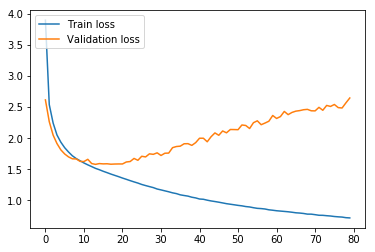

In [63]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

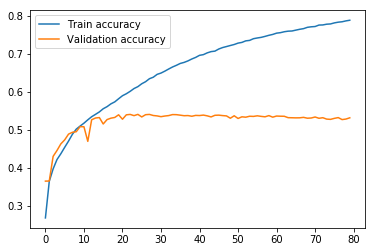

In [64]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Train accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

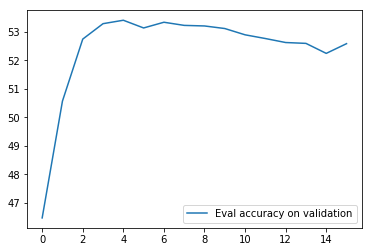

In [66]:
plt.plot(eval_acc)
plt.legend(['Eval accuracy on validation'], loc='lower right')
plt.show()


### Model 2 (same as Model 1 but with 3000 classes of answers)


In [79]:
def Word2VecModel(embedding_dim, dropout_rate):
    print("Creating text model...")
    model = Sequential()
    model.add(LSTM(units=512, return_sequences=True, input_shape=(None, embedding_dim)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=512, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1024, activation='tanh'))
    return model


def img_model(dropout_rate):
    print("Creating image model...")
    model = Sequential()
    model.add(Dense(1024, input_dim=4096, activation='tanh'))
    return model


def vqa_model(embedding_dim, dropout_rate, num_classes):
    vgg_model = img_model(dropout_rate)
    lstm_model = Word2VecModel(embedding_dim, dropout_rate)
    print("Merging final model...")
    fc_model = Sequential()
    fc_model.add(Merge([vgg_model, lstm_model], mode='mul'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(1000, activation='tanh'))
    fc_model.add(Dropout(dropout_rate))
    fc_model.add(Dense(num_classes, activation='softmax'))
    fc_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                     metrics=['accuracy'])
    return fc_model

In [80]:
# model parameters
dropout_rate = 0.5
embedding_size = 300
num_classes = 3000

# training parameters
num_epochs = 80
batch_size = 1000
num_batches_train = train_dim // batch_size
num_batches_val = val_dim // batch_size
eval_every = 5

train_loss, train_acc = [], []
val_loss, val_acc = [], []
eval_acc = []

In [81]:
model = vqa_model(embedding_size, dropout_rate, num_classes)

Creating image model...
Creating text model...
Merging final model...


/home/crisojog/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [ ]:
model.load_weights("models/model_2_weights.h5")

In [82]:
for k in range(num_epochs):
    loss, acc = train_epoch(k + 1, model, num_batches_train, batch_size, ques_train_map, ans_train_map, img_train_map, ques_train_ids, ques_to_img_train)
    train_loss.append(loss)
    train_acc.append(acc)
    loss, acc = val_epoch(k + 1, model, num_batches_val, batch_size, ques_val_map, ans_val_map, img_val_map, ques_val_ids, ques_to_img_val)
    val_loss.append(loss)
    val_acc.append(acc)
    if (k + 1) % eval_every == 0:
        model.save_weights("models/model_2/model_2_epoch_%d_weights.h5" % (k + 1), overwrite=True)
        eval_accuracy = evaluate(vqa_val, model, batch_size, ques_val_map, ans_val_map, img_val_map, id_to_ans)
        print ("Eval accuracy: %.2f" % eval_accuracy)
        eval_acc.append(eval_accuracy)

Val epoch 1:   0%|          | 0/121 [00:00<?, ?it/s]

Train loss: 4.27622095749	Accuracy: 0.257219807377


Train epoch 2:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 3.184185007	Accuracy: 0.330745874534


Val epoch 2:   2%|▏         | 2/121 [00:00<00:11, 10.30it/s]

Train loss: 3.10551607494	Accuracy: 0.33429823274


Train epoch 3:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.82469972739	Accuracy: 0.367262474423


Val epoch 3:   1%|          | 1/121 [00:00<00:12,  9.91it/s]

Train loss: 2.80233864256	Accuracy: 0.361737196335


Train epoch 4:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.6221645697	Accuracy: 0.382145629879


Val epoch 4:   1%|          | 1/121 [00:00<00:12,  9.74it/s]

Train loss: 2.59683849932	Accuracy: 0.388186628492


Train epoch 5:   0%|          | 1/248 [00:00<00:48,  5.12it/s]

Val loss: 2.44970405631	Accuracy: 0.410881781208


Val epoch 5:   1%|          | 1/121 [00:00<00:12,  9.53it/s]

Train loss: 2.46079249542	Accuracy: 0.404509022012


Val epoch 5: 100%|██████████| 121/121 [00:11<00:00, 10.84it/s]


Val loss: 2.32198463405	Accuracy: 0.426460752166


100%|██████████| 121512/121512 [00:11<00:00, 10227.66it/s]


loading VQA annotations and questions into memory...
0:00:02.649082
creating index...
index created!
Loading and preparing results...     
DONE (t=0.41s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 6:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 45.80


Val epoch 6:   1%|          | 1/121 [00:00<00:12,  9.99it/s]

Train loss: 2.35484157035	Accuracy: 0.417870961224


Train epoch 7:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.25272024485	Accuracy: 0.427292114311


Val epoch 7:   2%|▏         | 2/121 [00:00<00:11, 10.12it/s]

Train loss: 2.27970315631	Accuracy: 0.429750765227


Train epoch 8:   0%|          | 1/248 [00:00<00:47,  5.18it/s]

Val loss: 2.20227202982	Accuracy: 0.401791035396


Val epoch 8:   1%|          | 1/121 [00:00<00:12,  9.81it/s]

Train loss: 2.21385939716	Accuracy: 0.442915982935


Train epoch 9:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.13316660723	Accuracy: 0.463646053652


Val epoch 9:   2%|▏         | 2/121 [00:00<00:11, 10.35it/s]

Train loss: 2.16124787833	Accuracy: 0.458532103741


Train epoch 10:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.11639235952	Accuracy: 0.462661073195


Val epoch 10:   2%|▏         | 2/121 [00:00<00:11, 10.28it/s]

Train loss: 2.11634338866	Accuracy: 0.469648601336


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.08040738119	Accuracy: 0.477526156806


100%|██████████| 121512/121512 [00:11<00:00, 10503.82it/s]


loading VQA annotations and questions into memory...
0:00:02.653325
creating index...
index created!
Loading and preparing results...     
DONE (t=0.39s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 11:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 50.68


Val epoch 11:   2%|▏         | 2/121 [00:00<00:11, 10.22it/s]

Train loss: 2.08194468072	Accuracy: 0.478846818439


Train epoch 12:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.09477672746	Accuracy: 0.451076249442


Val epoch 12:   1%|          | 1/121 [00:00<00:12,  9.37it/s]

Train loss: 2.05154640727	Accuracy: 0.48787708043


Train epoch 13:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.0655208962	Accuracy: 0.487746470928


Val epoch 13:   1%|          | 1/121 [00:00<00:12,  9.49it/s]

Train loss: 2.02164170741	Accuracy: 0.495962079826


Train epoch 14:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.04481102342	Accuracy: 0.492725594339


Val epoch 14:   1%|          | 1/121 [00:00<00:12,  9.84it/s]

Train loss: 1.99935721539	Accuracy: 0.5019566164


Train epoch 15:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.05992464374	Accuracy: 0.484529466067


Val epoch 15:   2%|▏         | 2/121 [00:00<00:11, 10.38it/s]

Train loss: 1.97478921016	Accuracy: 0.508133141521


  1%|          | 1390/121512 [00:00<00:08, 13899.75it/s]

Val loss: 2.04703520556	Accuracy: 0.494948584373


100%|██████████| 121512/121512 [00:11<00:00, 10512.26it/s]


loading VQA annotations and questions into memory...
0:00:02.450841
creating index...
index created!
Loading and preparing results...     
DONE (t=0.39s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 16:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 52.51


Val epoch 16:   2%|▏         | 2/121 [00:00<00:11, 10.09it/s]

Train loss: 1.94918020918	Accuracy: 0.516173604291


Train epoch 17:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.02167244107	Accuracy: 0.496322128901


Val epoch 17:   2%|▏         | 2/121 [00:00<00:11, 10.17it/s]

Train loss: 1.92972791276	Accuracy: 0.523017928704


Train epoch 18:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.0322054016	Accuracy: 0.499792161587


Val epoch 18:   2%|▏         | 2/121 [00:00<00:11, 10.32it/s]

Train loss: 1.90840148488	Accuracy: 0.52883921401


Train epoch 19:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.02972509966	Accuracy: 0.503090485256


Val epoch 19:   2%|▏         | 2/121 [00:00<00:11, 10.35it/s]

Train loss: 1.88823058908	Accuracy: 0.535135086276


Train epoch 20:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.04746203005	Accuracy: 0.499412626776


Val epoch 20:   2%|▏         | 2/121 [00:00<00:11, 10.35it/s]

Train loss: 1.86904513692	Accuracy: 0.5406629768


  1%|▏         | 1658/121512 [00:00<00:07, 16579.86it/s]

Val loss: 2.02869661886	Accuracy: 0.504942978151


100%|██████████| 121512/121512 [00:11<00:00, 10733.65it/s]


loading VQA annotations and questions into memory...
0:00:02.453931
creating index...
index created!
Loading and preparing results...     
DONE (t=0.40s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 21:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 53.23


Val epoch 21:   2%|▏         | 2/121 [00:00<00:11, 10.50it/s]

Train loss: 1.84626078831	Accuracy: 0.548580898187


Train epoch 22:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.06390547591	Accuracy: 0.50080424842


Val epoch 22:   2%|▏         | 2/121 [00:00<00:11, 10.06it/s]

Train loss: 1.82614784583	Accuracy: 0.554951640145


Train epoch 23:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.07293138631	Accuracy: 0.506533405576


Val epoch 23:   1%|          | 1/121 [00:00<00:12,  9.64it/s]

Train loss: 1.8091520382	Accuracy: 0.56160035062


Train epoch 24:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.05128621986	Accuracy: 0.501454877095


Val epoch 24:   2%|▏         | 2/121 [00:00<00:11, 10.30it/s]

Train loss: 1.79096966794	Accuracy: 0.567361468471


Train epoch 25:   0%|          | 1/248 [00:00<00:47,  5.15it/s]

Val loss: 2.09350901682	Accuracy: 0.504084508946


Val epoch 25:   2%|▏         | 2/121 [00:00<00:11, 10.34it/s]

Train loss: 1.77092957969	Accuracy: 0.573706622455


  2%|▏         | 1852/121512 [00:00<00:06, 18519.80it/s]

Val loss: 2.08517100466	Accuracy: 0.502846502289


100%|██████████| 121512/121512 [00:11<00:00, 10642.42it/s]


loading VQA annotations and questions into memory...
0:00:02.499811
creating index...
index created!
Loading and preparing results...     
DONE (t=0.41s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 26:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 53.06


Val epoch 26:   1%|          | 1/121 [00:00<00:12,  9.96it/s]

Train loss: 1.75298865048	Accuracy: 0.580042060335


Train epoch 27:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.1229109941	Accuracy: 0.507039451137


Val epoch 27:   2%|▏         | 2/121 [00:00<00:11, 10.26it/s]

Train loss: 1.7349749796	Accuracy: 0.587002527152


Train epoch 28:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.13932680514	Accuracy: 0.508584698937


Val epoch 28:   1%|          | 1/121 [00:00<00:12,  9.86it/s]

Train loss: 1.71959166118	Accuracy: 0.591725367382


Train epoch 29:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.14368898383	Accuracy: 0.501500063726


Val epoch 29:   1%|          | 1/121 [00:00<00:12,  9.87it/s]

Train loss: 1.7028269891	Accuracy: 0.596870111386


Train epoch 30:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.16859190412	Accuracy: 0.500397605339


Val epoch 30:   1%|          | 1/121 [00:00<00:12,  9.93it/s]

Train loss: 1.68556428709	Accuracy: 0.602209820899


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.18540454435	Accuracy: 0.506443045768


100%|██████████| 121512/121512 [00:11<00:00, 10454.99it/s]


loading VQA annotations and questions into memory...
0:00:02.468597
creating index...
index created!
Loading and preparing results...     
DONE (t=0.38s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy

Train epoch 31:   0%|          | 0/248 [00:00<?, ?it/s]


Eval accuracy: 53.45


Val epoch 31:   2%|▏         | 2/121 [00:00<00:11, 10.22it/s]

Train loss: 1.67326684159	Accuracy: 0.607392407449


Train epoch 32:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.21441649765	Accuracy: 0.506036395346


Val epoch 32:   1%|          | 1/121 [00:00<00:12,  9.95it/s]

Train loss: 1.65734041621	Accuracy: 0.611859304005


Train epoch 33:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.19645507472	Accuracy: 0.502087434377


Val epoch 33:   1%|          | 1/121 [00:00<00:12,  9.96it/s]

Train loss: 1.64180280462	Accuracy: 0.615744850036


Train epoch 34:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.16493450553	Accuracy: 0.506090617275


Val epoch 34:   1%|          | 1/121 [00:00<00:12,  9.96it/s]

Train loss: 1.62865737546	Accuracy: 0.620910999454


Train epoch 35:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.25836295173	Accuracy: 0.505141779362


Val epoch 35:   1%|          | 1/121 [00:00<00:12,  9.86it/s]

Train loss: 1.61484681053	Accuracy: 0.624992349919


  1%|          | 1000/121512 [00:00<00:12, 9501.99it/s]

Val loss: 2.23459880031	Accuracy: 0.498337278599


100%|██████████| 121512/121512 [00:11<00:00, 10724.81it/s]


loading VQA annotations and questions into memory...
0:00:02.462762
creating index...
index created!
Loading and preparing results...     
DONE (t=0.40s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 36:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 52.89


Val epoch 36:   2%|▏         | 2/121 [00:00<00:11, 10.39it/s]

Train loss: 1.60130357941	Accuracy: 0.628540073441


Train epoch 37:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.27308968413	Accuracy: 0.502991092345


Val epoch 37:   1%|          | 1/121 [00:00<00:12,  9.94it/s]

Train loss: 1.58943928255	Accuracy: 0.633139329497


Train epoch 38:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.27144959745	Accuracy: 0.504391749343


Val epoch 38:   2%|▏         | 2/121 [00:00<00:11, 10.28it/s]

Train loss: 1.57593257286	Accuracy: 0.636846614642


Train epoch 39:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.28187521055	Accuracy: 0.50336158437


Val epoch 39:   1%|          | 1/121 [00:00<00:12,  9.99it/s]

Train loss: 1.56705835999	Accuracy: 0.640196758716


Train epoch 40:   0%|          | 1/248 [00:00<00:48,  5.08it/s]

Val loss: 2.36037631796	Accuracy: 0.502114538302


Val epoch 40:   2%|▏         | 2/121 [00:00<00:11, 10.25it/s]

Train loss: 1.55490447091	Accuracy: 0.642003865404


  1%|          | 1000/121512 [00:00<00:12, 9876.06it/s]

Val loss: 2.31801208363	Accuracy: 0.498400534488


100%|██████████| 121512/121512 [00:11<00:00, 10661.71it/s]


loading VQA annotations and questions into memory...
0:00:02.454311
creating index...
index created!
Loading and preparing results...     
DONE (t=0.38s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 41:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 52.85


Val epoch 41:   2%|▏         | 2/121 [00:00<00:11, 10.35it/s]

Train loss: 1.54197481388	Accuracy: 0.647551914487


Train epoch 42:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.37945787919	Accuracy: 0.503036269694


Val epoch 42:   2%|▏         | 2/121 [00:00<00:11, 10.34it/s]

Train loss: 1.53308692913	Accuracy: 0.650428721279


Train epoch 43:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.36531053117	Accuracy: 0.503045307676


Val epoch 43:   2%|▏         | 2/121 [00:00<00:11, 10.26it/s]

Train loss: 1.5233890175	Accuracy: 0.652158318523


Train epoch 44:   0%|          | 1/248 [00:00<00:44,  5.53it/s]

Val loss: 2.42012283536	Accuracy: 0.497415556886


Val epoch 44:   2%|▏         | 2/121 [00:00<00:11, 10.31it/s]

Train loss: 1.50983264916	Accuracy: 0.656355901305


Train epoch 45:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.45502688332	Accuracy: 0.496602267901


Val epoch 45:   1%|          | 1/121 [00:00<00:12,  9.83it/s]

Train loss: 1.50185134953	Accuracy: 0.65947538439


  1%|          | 1000/121512 [00:00<00:12, 9694.05it/s]

Val loss: 2.45249155233	Accuracy: 0.498219805717


100%|██████████| 121512/121512 [00:11<00:00, 10619.99it/s]


loading VQA annotations and questions into memory...
0:00:02.464456
creating index...
index created!
Loading and preparing results...     
DONE (t=0.40s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 46:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 52.86


Val epoch 46:   2%|▏         | 2/121 [00:00<00:11, 10.32it/s]

Train loss: 1.49200708933	Accuracy: 0.662591390833


Train epoch 47:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.47613619091	Accuracy: 0.503397731371


Val epoch 47:   1%|          | 1/121 [00:00<00:12,  9.82it/s]

Train loss: 1.47801048179	Accuracy: 0.667223444931


Train epoch 48:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.47211687794	Accuracy: 0.505015272567


Val epoch 48:   1%|          | 1/121 [00:00<00:12,  9.95it/s]

Train loss: 1.4712839038	Accuracy: 0.669178030713


Train epoch 49:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.46330979601	Accuracy: 0.500786177032


Val epoch 49:   2%|▏         | 2/121 [00:00<00:11, 10.28it/s]

Train loss: 1.46567740885	Accuracy: 0.67124036101


Train epoch 50:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.49171757763	Accuracy: 0.501039198502


Val epoch 50:   2%|▏         | 2/121 [00:00<00:11, 10.28it/s]

Train loss: 1.45609005028	Accuracy: 0.67313376287


  0%|          | 0/121512 [00:00<?, ?it/s]

Val loss: 2.49693692639	Accuracy: 0.500903647795


100%|██████████| 121512/121512 [00:11<00:00, 10634.07it/s]


loading VQA annotations and questions into memory...
0:00:02.452799
creating index...
index created!
Loading and preparing results...     
DONE (t=0.40s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 51:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 52.95


Val epoch 51:   2%|▏         | 2/121 [00:00<00:11, 10.26it/s]

Train loss: 1.4456225645	Accuracy: 0.675862402793


Train epoch 52:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.53156156406	Accuracy: 0.504554408189


Val epoch 52:   2%|▏         | 2/121 [00:00<00:11, 10.32it/s]

Train loss: 1.43356034184	Accuracy: 0.679452362537


Train epoch 53:   0%|          | 1/248 [00:00<00:48,  5.13it/s]

Val loss: 2.52848661083	Accuracy: 0.500885577834


Val epoch 53:   2%|▏         | 2/121 [00:00<00:11, 10.34it/s]

Train loss: 1.42923433385	Accuracy: 0.681942802805


Train epoch 54:   0%|          | 1/248 [00:00<00:48,  5.09it/s]

Val loss: 2.62704692487	Accuracy: 0.498671626928


Val epoch 54:   1%|          | 1/121 [00:00<00:12,  9.83it/s]

Train loss: 1.42095252106	Accuracy: 0.683271607683


Train epoch 55:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.55430464811	Accuracy: 0.501671755108


Val epoch 55:   2%|▏         | 2/121 [00:00<00:11, 10.30it/s]

Train loss: 1.41424999671	Accuracy: 0.685846339587


  1%|          | 1000/121512 [00:00<00:12, 9673.25it/s]

Val loss: 2.65054219046	Accuracy: 0.497885449826


100%|██████████| 121512/121512 [00:11<00:00, 10669.85it/s]


loading VQA annotations and questions into memory...
0:00:02.459869
creating index...
index created!
Loading and preparing results...     
DONE (t=0.40s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 56:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 52.79


Val epoch 56:   2%|▏         | 2/121 [00:00<00:11, 10.35it/s]

Train loss: 1.40439058141	Accuracy: 0.688947873573


Train epoch 57:   0%|          | 1/248 [00:00<00:47,  5.16it/s]

Val loss: 2.64408936124	Accuracy: 0.501283185544


Val epoch 57:   2%|▏         | 2/121 [00:00<00:11, 10.34it/s]

Train loss: 1.39589361153	Accuracy: 0.691011330815


Train epoch 58:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.66271835748	Accuracy: 0.501003051741


Val epoch 58:   1%|          | 1/121 [00:00<00:12,  9.94it/s]

Train loss: 1.38940849034	Accuracy: 0.692452666645


Train epoch 59:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.61329047773	Accuracy: 0.502195873654


Val epoch 59:   1%|          | 1/121 [00:00<00:12,  9.87it/s]

Train loss: 1.38239658808	Accuracy: 0.694663558556


Train epoch 60:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.70570302169	Accuracy: 0.494767849713


Val epoch 60:   2%|▏         | 2/121 [00:00<00:11, 10.27it/s]

Train loss: 1.37652323922	Accuracy: 0.696584506863


  1%|          | 1000/121512 [00:00<00:12, 9935.72it/s]

Val loss: 2.63263587037	Accuracy: 0.499421661278


100%|██████████| 121512/121512 [00:11<00:00, 10652.78it/s]


loading VQA annotations and questions into memory...
0:00:02.458524
creating index...
index created!
Loading and preparing results...     
DONE (t=0.40s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 61:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 52.82


Val epoch 61:   1%|          | 1/121 [00:00<00:12,  9.90it/s]

Train loss: 1.36812816788	Accuracy: 0.700146919969


Train epoch 62:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.69665621091	Accuracy: 0.499024049039


Val epoch 62:   2%|▏         | 2/121 [00:00<00:11, 10.35it/s]

Train loss: 1.35835065547	Accuracy: 0.701321874035


Train epoch 63:   0%|          | 1/248 [00:00<00:47,  5.15it/s]

Val loss: 2.72405358458	Accuracy: 0.498599339127


Val epoch 63:   2%|▏         | 2/121 [00:00<00:11, 10.39it/s]

Train loss: 1.35273405763	Accuracy: 0.703428555582


Train epoch 64:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.78995987714	Accuracy: 0.499186708174


Val epoch 64:   1%|          | 1/121 [00:00<00:12,  9.99it/s]

Train loss: 1.3478096548	Accuracy: 0.705075738205


Train epoch 65:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.8168822692	Accuracy: 0.497289039897


Val epoch 65:   2%|▏         | 2/121 [00:00<00:11, 10.28it/s]

Train loss: 1.34349987316	Accuracy: 0.705414726028


  1%|          | 1000/121512 [00:00<00:12, 9960.04it/s]

Val loss: 2.80363182896	Accuracy: 0.499033086835


100%|██████████| 121512/121512 [00:11<00:00, 10621.95it/s]


loading VQA annotations and questions into memory...
0:00:02.465823
creating index...
index created!
Loading and preparing results...     
DONE (t=0.40s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 66:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 52.82


Val epoch 66:   2%|▏         | 2/121 [00:00<00:11, 10.24it/s]

Train loss: 1.33412738249	Accuracy: 0.708248974537


Train epoch 67:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.81661492474	Accuracy: 0.49878910217


Val epoch 67:   1%|          | 1/121 [00:00<00:12,  9.90it/s]

Train loss: 1.32788470661	Accuracy: 0.710363618881


Train epoch 68:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.77047179072	Accuracy: 0.49785834077


Val epoch 68:   1%|          | 1/121 [00:00<00:12,  9.98it/s]

Train loss: 1.32403957843	Accuracy: 0.712346200648


Train epoch 69:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.84463462286	Accuracy: 0.500234943743


Val epoch 69:   2%|▏         | 2/121 [00:00<00:11, 10.32it/s]

Train loss: 1.31599956693	Accuracy: 0.713343711474


Train epoch 70:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.79952554211	Accuracy: 0.497885455513


Val epoch 70:   1%|          | 1/121 [00:00<00:12,  9.99it/s]

Train loss: 1.30793420487	Accuracy: 0.717159082031


  1%|          | 1000/121512 [00:00<00:12, 9870.20it/s]

Val loss: 2.82583151577	Accuracy: 0.500596409907


100%|██████████| 121512/121512 [00:11<00:00, 10622.26it/s]


loading VQA annotations and questions into memory...
0:00:02.462899
creating index...
index created!
Loading and preparing results...     
DONE (t=0.38s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 71:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 52.92


Val epoch 71:   2%|▏         | 2/121 [00:00<00:11, 10.22it/s]

Train loss: 1.30756359384	Accuracy: 0.71696116317


Train epoch 72:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.83299457759	Accuracy: 0.492337026509


Val epoch 72:   2%|▏         | 2/121 [00:00<00:11, 10.26it/s]

Train loss: 1.29887970597	Accuracy: 0.719288497676


Train epoch 73:   0%|          | 1/248 [00:00<00:48,  5.07it/s]

Val loss: 2.8654840563	Accuracy: 0.498075217724


Val epoch 73:   2%|▏         | 2/121 [00:00<00:11, 10.40it/s]

Train loss: 1.29188293437	Accuracy: 0.720496542205


Train epoch 74:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.83738123627	Accuracy: 0.498210764773


Val epoch 74:   2%|▏         | 2/121 [00:00<00:11, 10.27it/s]

Train loss: 1.28904347972	Accuracy: 0.722354124359


Train epoch 75:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.90096147036	Accuracy: 0.497081200238


Val epoch 75:   2%|▏         | 2/121 [00:00<00:11, 10.32it/s]

Train loss: 1.28035725912	Accuracy: 0.724006747426


  1%|          | 1000/121512 [00:00<00:12, 9952.91it/s]

Val loss: 2.8880158799	Accuracy: 0.495563063317


100%|██████████| 121512/121512 [00:11<00:00, 10653.41it/s]


loading VQA annotations and questions into memory...
0:00:02.467607
creating index...
index created!
Loading and preparing results...     
DONE (t=0.39s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% 

Train epoch 76:   0%|          | 0/248 [00:00<?, ?it/s]

Done computing accuracy
Eval accuracy: 52.47


Val epoch 76:   1%|          | 1/121 [00:00<00:12,  9.67it/s]

Train loss: 1.2727324989	Accuracy: 0.725888190604


Train epoch 77:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.97066658337	Accuracy: 0.497569168447


Val epoch 77:   2%|▏         | 2/121 [00:00<00:11, 10.32it/s]

Train loss: 1.27038580979	Accuracy: 0.727800197541


Train epoch 78:   0%|          | 1/248 [00:00<00:47,  5.18it/s]

Val loss: 2.91835770303	Accuracy: 0.497677609086


Val epoch 78:   2%|▏         | 2/121 [00:00<00:11, 10.36it/s]

Train loss: 1.2662343607	Accuracy: 0.727467904904


Train epoch 79:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.91034345823	Accuracy: 0.49810232849


Val epoch 79:   2%|▏         | 2/121 [00:00<00:11, 10.34it/s]

Train loss: 1.25931065734	Accuracy: 0.729999651654


Train epoch 80:   0%|          | 0/248 [00:00<?, ?it/s]

Val loss: 2.9123407537	Accuracy: 0.491939415838


Val epoch 80:   1%|          | 1/121 [00:00<00:12,  9.61it/s]

Train loss: 1.25346967127	Accuracy: 0.731372125846


  1%|          | 1000/121512 [00:00<00:12, 9867.58it/s]

Val loss: 2.8867046152	Accuracy: 0.495987778358


100%|██████████| 121512/121512 [00:11<00:00, 10675.04it/s]


loading VQA annotations and questions into memory...
0:00:02.453244
creating index...
index created!
Loading and preparing results...     
DONE (t=0.40s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy
Eval accuracy: 52.43


In [97]:
model.load_weights("models/model_2/model_2_epoch_30_weights.h5")

In [98]:
evaluate(vqa_val, model, batch_size, ques_val_map, ans_val_map, img_val_map, id_to_ans, verbose=True)

100%|██████████| 121512/121512 [00:11<00:00, 10519.80it/s]


loading VQA annotations and questions into memory...
0:00:02.533034
creating index...
index created!
Loading and preparing results...     
DONE (t=0.39s)
creating index...
index created!
computing accuracy
Finshed Percent: [####################] 99% Done computing accuracy


Overall Accuracy is: 53.45

Per Question Type Accuracy is the following:
are there : 83.19
what brand : 33.80
what room is : 81.76
what color is : 45.98
is : 78.75
are they : 75.61
what number is : 4.61
what sport is : 84.24
are : 74.01
is the : 73.27
what is the person : 46.68
how many : 39.55
does this : 77.55
is there a : 88.12
is he : 77.31
what : 35.42
does the : 77.82
is the person : 75.76
where is the : 25.72
what animal is : 58.97
how : 21.64
what is the woman : 39.46
none of the above : 51.88
who is : 22.52
is the woman : 75.92
are the : 73.37
how many people are : 40.80
what is on the : 33.31
has : 78.54
was : 77.22
what type of : 43.35
is this an : 75.83
do : 72.72
what is the man : 49.30
which : 37.87
a

53.45

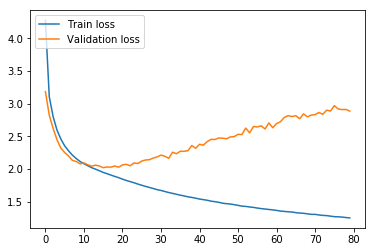

In [83]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['Train loss', 'Validation loss'], loc='upper left')
plt.show()

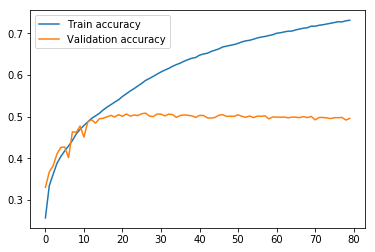

In [84]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.legend(['Train accuracy', 'Validation accuracy'], loc='upper left')
plt.show()

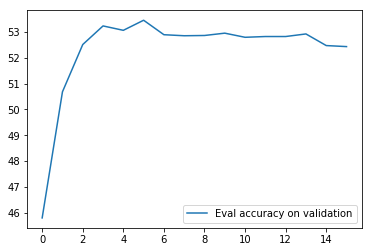

In [88]:
plt.plot(eval_acc)
plt.legend(['Eval accuracy on validation'], loc='lower right')
plt.show()

In [99]:
print "Best accuracy %.02f on epoch %d" % (max(eval_acc), (1 + np.argmax(np.array(eval_acc))) * eval_every)

Best accuracy 53.45 on epoch 30
